# Part B - Diffusion Models

## Imports

In [8]:
from typing import List, Set, Dict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx
import copy
import time
from utils.graph_stats import calc_degree_histogram, plot_degree_histogram, build_graph, clustering_coefficient
from utils.diffusion_models import LTM, ICM, compute_lethality_effect, plot_lethality_effect
import utils.config as config
# from main import choose_who_to_vaccinate, ICM, LTM, compute_lethality_effect, plot_lethality_effect

## Background Story

More than 2.7 million deaths and 125 million cases worldwide were brought to the world by the Covid-19 pandemic. 

Many experts warn that the new globalized world is very vulnerable to such contagious diseases. Although Covid-19 is far from over, we must prepare for the next inevitable pandemic called: "pandemic X."

The Israeli minister of health appointed you to study and simulate different Diffusion models in order to understand the consequences of "pandemic X," taking into account the following variables:

## Variables

Contagion (static) – A real number that describes how contagious the disease is. 

Lethality (static) – The probability for an infected person to die from the disease. 

Concern (dynamic) – How worried is a particular person about the disease. The concern will cause a person to alter their behavior and reduce their chance of being infected.

To formalize our notation, we also define the following sets:

## Sets

${V}$ – The set of all people (Vertices in our graph) 

${E}$ – The set of all undirected relations between two people (Edges in our graph) 

${I^0}$ – The set of initial patients ${I^0}\subset{V}$

${S^t}$ – The set of Susceptible people at the end of iteration t (who are not infected), ${S^0}={V}\setminus{I^0}$

${I^t}$ – The set of Infected and alive people, at the end of iteration t 

${R^t}$ – The set of Removed (infected and deceased) people at the end of iteration t 

Pay attention that ${S^t}$, ${I^t}$, ${R^t}$ are disjoint, that is, ${S^t}\cap{I^t}={S_t}\cap{R^t}={I^t}\cap{R^t}=\emptyset , \forall t$

In [9]:
"""Global Hyper-parameters"""

LETHALITY_ = 0.15
CONTAGION_ = 0.8

## Datasets

In [10]:
# filename_patients0 = "data/patients0.csv"
patients_df = pd.read_csv(config.filename_patients0, header=None)
print(f'size of Patients0 dataset is: {len(patients_df)}\n')
patients_df.head()

size of Patients0 dataset is: 50



,0
0,19091
1,13254
2,5162
3,25182
4,10872


In [11]:
# filename_B_C = "data\PartB-C.csv"
df_B_C = pd.read_csv(config.filename_B_C, header=None)
print(f'size of PartB-C dataset is: {len(df_B_C)}\n')
df_B_C.head()

size of PartB-C dataset is: 92753



,0,1,2
0,from,to,w
1,0,14270,0.410087555
2,0,16976,0.270293298
3,0,12029,0.053567498
4,0,3001,0.819193013


## Linear threshold model

- Each edge ${(u,v)} \in {E}$ has a weight ${w_{uv}} \in {[0,1]}$ that represents the relationship strength of persons u and v, which implies their exposure to each other
- Each person v has a concern variable ${c_v^t} = \frac{|\left\{{u}:{(u,v)}\in{E}\right\}\cap{I^{t-1}}|}{|\left\{{u}:{(u,v)}\in{E}\right\}|}*$
- In every step ${t} = 1,2,...:$

    1. Every ${v} \in {S^{t-1}}$ watchse all of her infected neighbors ${cv_n} = \left\{{u}:{(u,v)}\in{E}\right\}\cap{I^{t-1}}$
        - If ${Contagion} * \sum_{{u} \in {cv_n}} {W_{u,v}} \geq {c_v^{t-1}}$ , then ${v}$ is in ${I^t}$
    2. ${S^t}={V}/{I^t}$
    3. Every ${v} \in {S^{t}}$ updates her concern ${c_v^t}$


$*$ Pay attention that ${c_v^t}$ depends on ${I^{t-1}}$ the reason for it is to simulate the case where a person is first exposed to her infected friend and only afterwards aware that her friend was infected.

In [12]:
patients_list = patients_df.iloc[:, 0].tolist()
G = build_graph(filename=config.filename_B_C)
start_time = time.time()
infected_after_t_iterations_LTM = LTM(graph=G, patients_0=patients_list[:30], iterations=6)
print("1:  --- %s seconds ---" % (time.time() - start_time))

1:  --- 1.3650009632110596 seconds ---


## Independent cascade model (stochastic)

- Each edge ${(u,v)} \in {E}$ has a weight ${w_{uv}} \in {[0,1]}$ such that if person u is infected, then ${w_{uv}}$ will affect ${P_{u,v}^{t}}$ which is defined below
- If a person is infected, they are removed with probability Lethality without infecting anyone else.
- Each person v has a concern variable ${c_v^t} = min(\frac{|\left\{{u}:{(u,v)}\in{E}\right\}\cap{I^{t-1}} + 3*\left\{{u}:{(u,v)}\in{E}\right\}\cap{R^{t-1}}|}{|\left\{{u}:{(u,v)}\in{E}\right\}|}) **$
- Denote ${NI^t}$ are the new nodes who were infected during iteration t
- Denote ${P_{u,v}^{t}}$ as the probability for person u to pass the virus to person v during iteration t, then: ${P_{u,v}^{t}} = min(1, Contagion*{w_{uv}}*{c_v^{t-1}})$
- On ${t_0}$ patients also die w.p Lethality
- In every step ${t} = 1,2,...:$
    1. For each ${v} \in {S^{t-1}}$ and ${u} \in {NI^{t-1}}$ u infects v w.p ${P_{u,v}^{t}}$
        - If infection occurs, v is added to ${NI^t}$
    2. Every ${v} \in {NI^{t}}$ is added to ${R^t}$ with probability Lethality
    3. ${R^t} = {R^t}\cup{R^{t-1}}$
    4. ${I^t} = ({I^{t-1}}\cup{NI^t})\setminus{R^t}$
    5. ${S^t} = {V}\setminus({I^t}\cup{R^t})$
    6. Each ${v} \in {S^t}$ updates concern ${c_v^t}$
    

$**$ Pay attention that ${c_v^t}$ depends on ${I^{t-1}}, {R^{t-1}}$ the reason for it is to simulate the case where a person is first exposed to her infected friend or removed and only afterwards aware that her friend was infected or removed.

In [13]:
start_time = time.time()
runs = 30
count_infected_list = []
count_deceased_list = []
for run in range(runs):
    infected_after_t_iterations_ICM, deceased_after_t_iterations_ICM = ICM(graph=G, patients_0=patients_list[:50], 
                                                                           iterations=6)
    count_deceased_list.append(len(deceased_after_t_iterations_ICM))
    count_infected_list.append(len(infected_after_t_iterations_ICM))
print(f'mean infected per iter:{sum(count_infected_list) / 30}')
print(f'mean deceased per iter:{sum(count_deceased_list) / 30}')
print("2:  --- %s seconds ---" % (time.time() - start_time))

mean infected per iter:11797.866666666667
mean deceased per iter:2695.866666666667
2:  --- 359.53219056129456 seconds ---


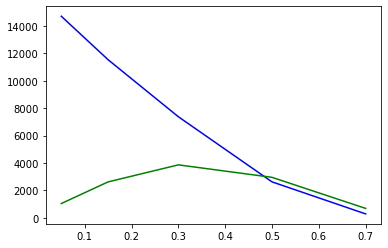

3:  --- 1127.6660182476044 seconds ---



In [14]:
start_time = time.time()
dict_mean_deceased, dict_mean_infected = compute_lethality_effect(graph=G, t=6)
plot_lethality_effect(dict_mean_deceased, dict_mean_infected)
print("3:  --- %s seconds ---" % (time.time() - start_time))
print()